## Basic Data Exploration 

Plan of action: 
* Load in data
* extract lat/lon and number of mosquitoes and whether WNV present
* Use R code to do geospatial modelling
* Get xgboost code working
* get keras code working
* combine submission

In [53]:
%pylab inline
from IPython.display import display, HTML
import os
import seaborn as sns
import pandas as pd
subm_folder = './submissions'
from sklearn.cluster import KMeans
import datetime

Populating the interactive namespace from numpy and matplotlib


In [54]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [55]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [56]:
#print lengths of dataframes
print (len(df_test.index))
print (len(df_train.index))

116293
10506


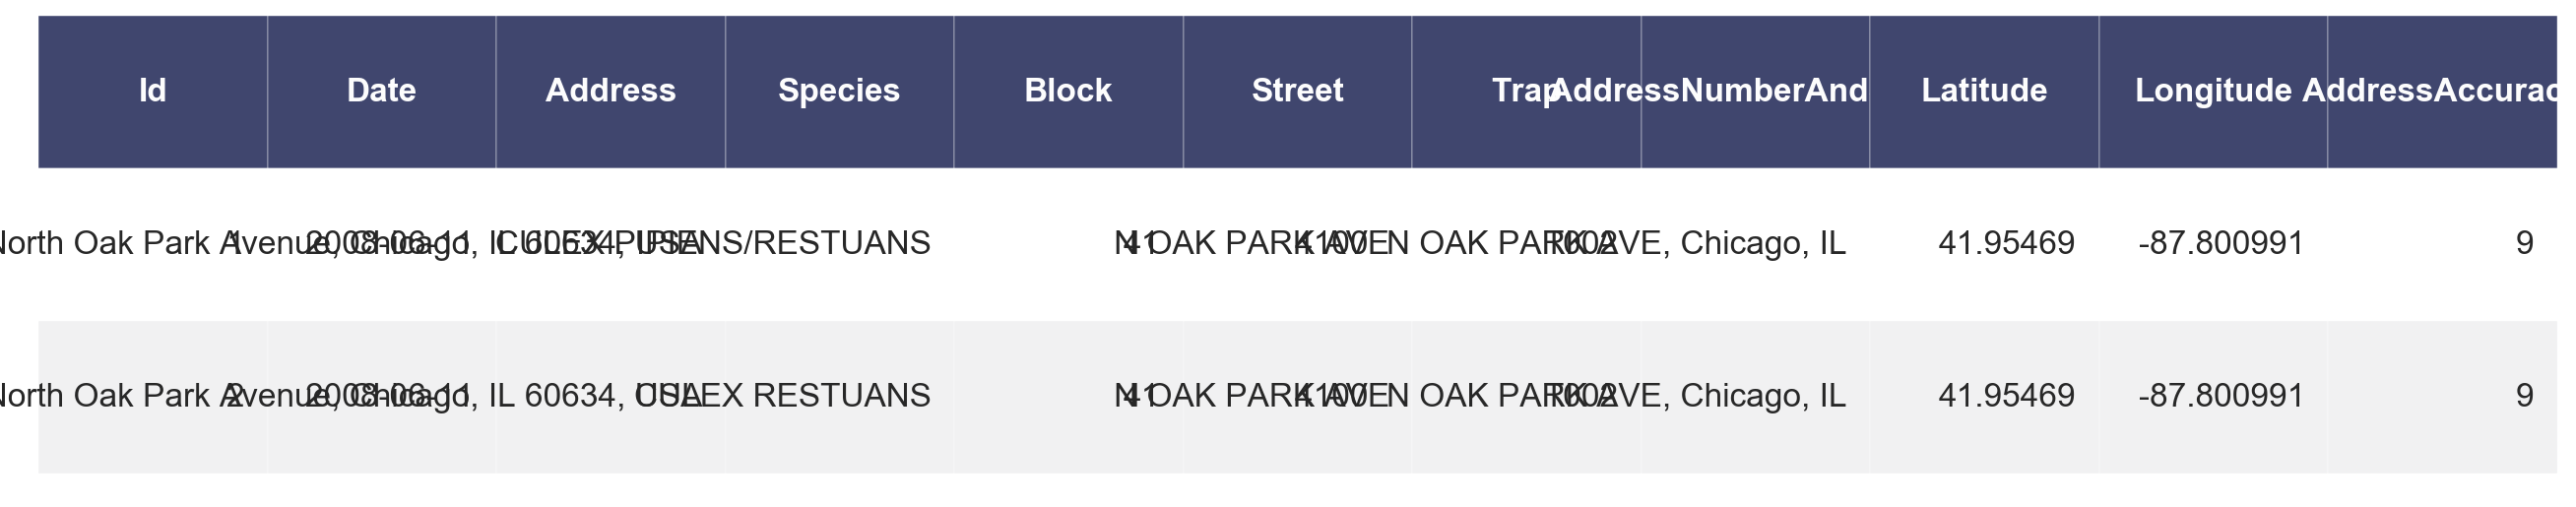

In [57]:
render_mpl_table(df_test.iloc[0:2],row_height=2.0,font_size=24);

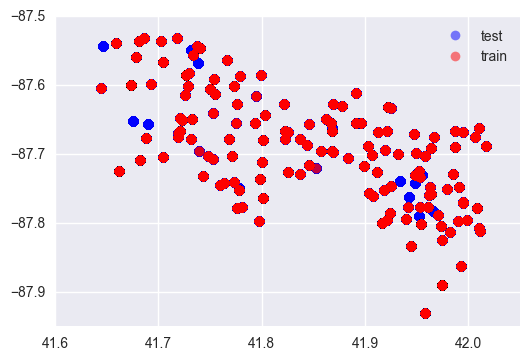

In [58]:
plt.plot(df_test['Latitude'],df_test['Longitude'],'bo',label='test',alpha=0.5);
plt.plot(df_train['Latitude'],df_train['Longitude'],'ro',label='train',alpha=0.5);
plt.legend();

Lots of overlap. Let's look at the unique locations.

In [59]:
addresses = df_train.groupby('Address').groups

In [60]:
print('Total locations: {}'.format(len(addresses.keys())))

Total locations: 138


Create some labels via k means clustering

In [61]:
ad_df = df_train.groupby('Address').mean()

X = ad_df[['Latitude','Longitude']].get_values()
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
labels = kmeans.labels_

ad_df['label'] = labels

In [62]:
import folium
from folium.plugins import MarkerCluster


latm = df_test['Latitude'].mean()
longm = df_test['Longitude'].mean()
m = folium.Map(location=[latm, longm])
i = 0
for label in labels:
    marker_cluster = MarkerCluster().add_to(m)
    cluster_addresses = ad_df[ad_df['label']==label]
    for index,row in cluster_addresses.iterrows():
        if i < 100: #folium can't seem to cope with too many points, which is annoying.
            
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                popup='Prob. WNV: {:.2f}, average mosquitoes: {:.2f}'.format(row['WnvPresent'],row['NumMosquitos'])
            ).add_to(marker_cluster)
            i+=1
        

In [63]:
m

In [64]:
m.save('map.html')

## Leaky feature exploration

There's an issue with how the data is aggregated. The more readings there are on the same date, the more likely WNV is present. Let's explore this.

In [31]:
def plotGroupedBy(col):
    wnv_present = df_train.groupby([col]).sum()['WnvPresent']>0
    present_counts = df_train.groupby([col]).count()['WnvPresent'][wnv_present].get_values()
    npresent_counts = df_train.groupby([col]).count()['WnvPresent'][-wnv_present].get_values()
    plt.hist([present_counts,npresent_counts], 50, stacked=True,label=['present','not present'])
    plt.legend();

## Plot of address counts where Wnv present versus where it isn't

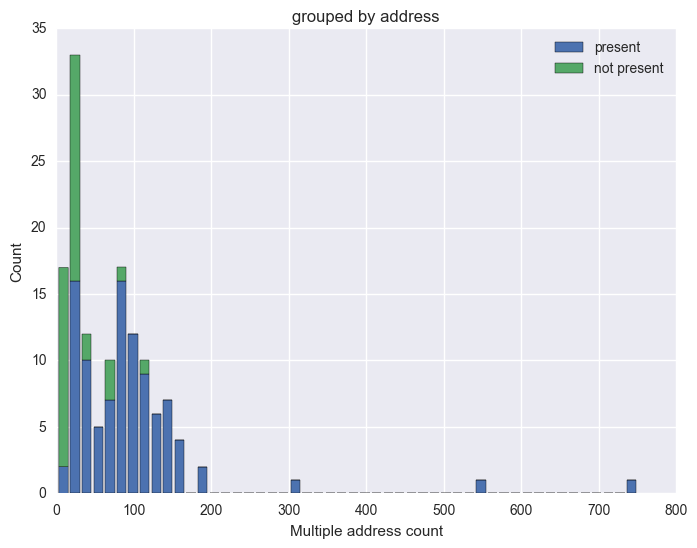

In [33]:
plt.figure(figsize=(8,6));
plotGroupedBy('Address');
plt.title('grouped by address');
plt.xlabel('Multiple address count');
plt.ylabel('Count');

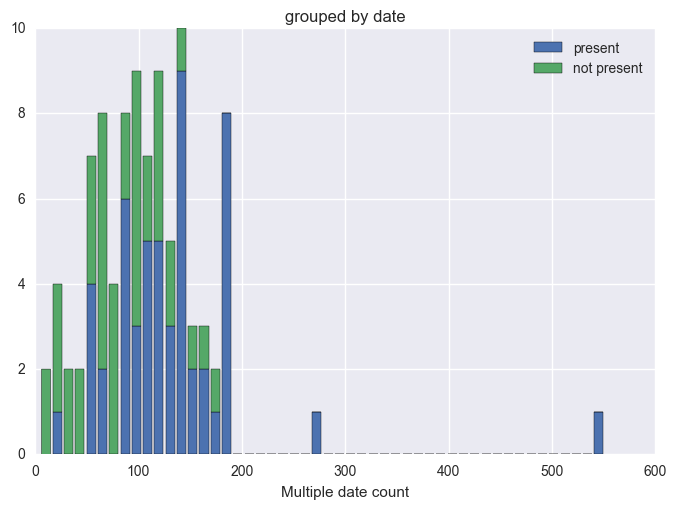

In [12]:
plotGroupedBy('Date');
plt.title('grouped by date');
plt.xlabel('Multiple date count');

### Mean Wnv compared to total count

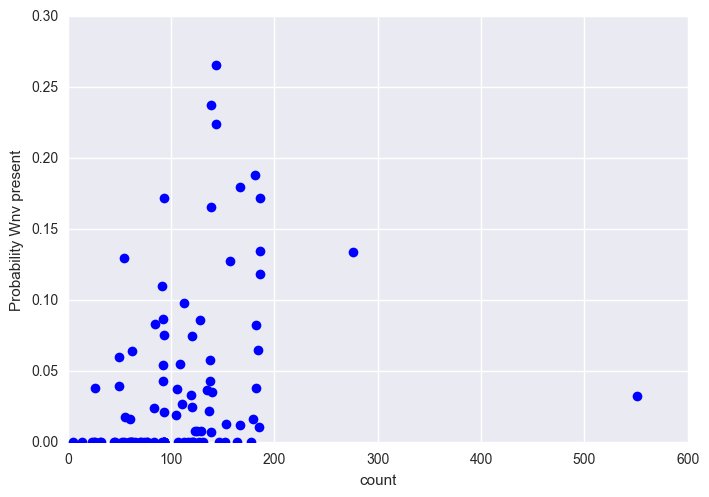

In [14]:
x = df_train.groupby(['Date']).count()['WnvPresent']
y = df_train.groupby(['Date']).mean()['WnvPresent']
plt.plot(x,y,'bo');
plt.xlabel('count');
plt.ylabel('Probability Wnv present');

# Exploit Leaky feature

## Training dataset

In [43]:
# DateCount
dt_count = df_train.groupby('Date').count()[['WnvPresent']] #get mutiple counts on a certain date
dt_count.columns = ['DateCount'] #create new column for how many times date repeated.
train = pd.merge(df_train, dt_count, how='inner', left_on='Date', right_index=True)
cnt_pred = np.array(train['DateCount'])
cnt_pred = 1.0*(cnt_pred - cnt_pred.min()) / (cnt_pred.max() - cnt_pred.min()) #normalize value to get prob.


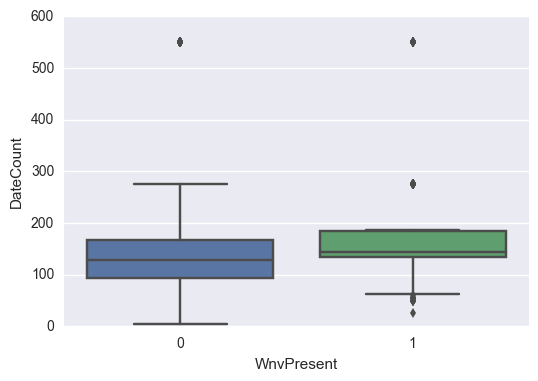

In [48]:
sns.boxplot(x='WnvPresent',y='DateCount',data=train)

## Test dataset

In [63]:
# DateCount
dt_count = df_test.groupby('Date').count()[['Id']] #get mutiple counts on a certain date
dt_count.columns = ['DateCount'] #create new column for how many times date repeated.
test = pd.merge(df_test, dt_count, how='inner', left_on='Date', right_index=True)
cnt_pred = np.array(test['DateCount'])
cnt_pred = 1.0*(cnt_pred - cnt_pred.min()) / (cnt_pred.max() - cnt_pred.min()) #normalize value to get prob.

#prepare submission
ss = pd.DataFrame(columns=['Id','WnvPresent'])
ss['WnvPresent'] = cnt_pred
ss['Id'] = test.index + 1
ss.to_csv(os.path.join(subm_folder, 'DateCount.csv'), index=False)

scores 0.75071, which would have put me in 529th place

# Import Weather

In [142]:
df_weather= pd.read_csv('./data/weather.csv')

In [146]:
df_weather.columns

Index([u'Station', u'Date', u'Tmax', u'Tmin', u'Tavg', u'Depart', u'DewPoint',
       u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset', u'CodeSum',
       u'Depth', u'Water1', u'SnowFall', u'PrecipTotal', u'StnPressure',
       u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed'],
      dtype='object')

# Explore Mosquito species

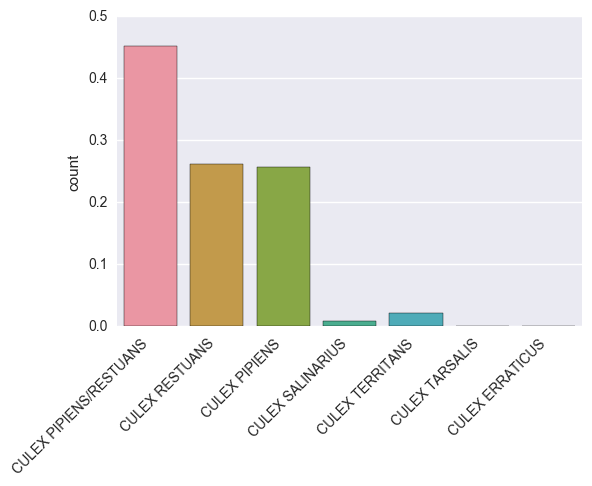

In [30]:
labels = []
counts = []
for spec in df_train[u'Species'].unique():
    labels.append(spec)
    counts.append((df_train['Species']==spec).mean())
    
sns.barplot(x=labels,y=counts);
plt.xticks(rotation=45,ha='right');
plt.ylabel('count');

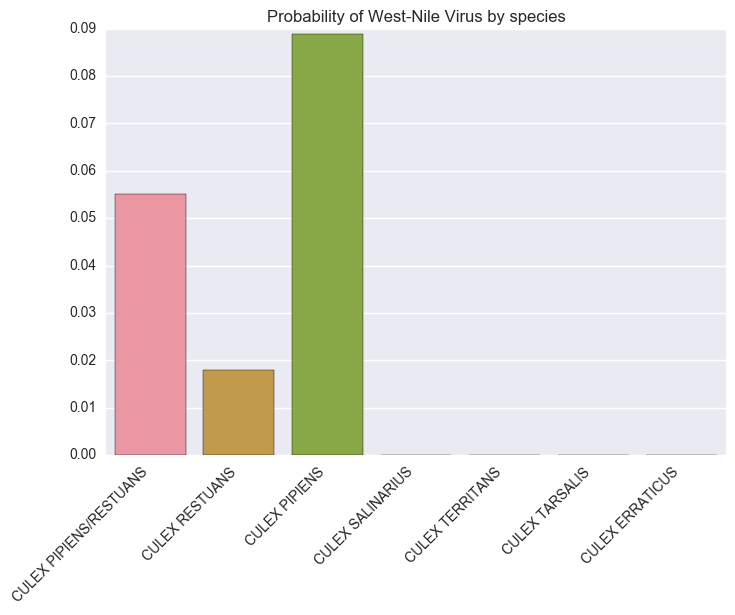

In [16]:
labels = []
counts = []
for spec in df_train[u'Species'].unique():
    labels.append(spec)
    
    sr = (df_train['Species']==spec)
    
    counts.append(df_train[sr]['WnvPresent'].mean())
    
sns.barplot(x=labels,y=counts);
plt.xticks(rotation=45,ha='right');
plt.title('Probability of West-Nile Virus by species');

## Look at how mosquitos are distributed in traps

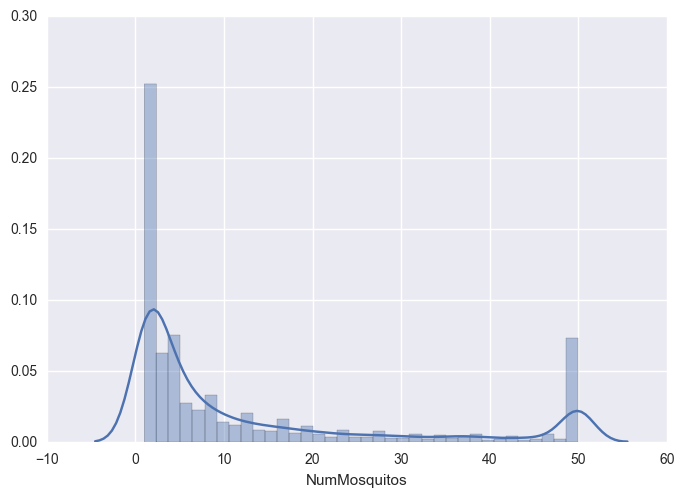

In [18]:
sns.distplot(df_train['NumMosquitos']);

Data is capped at 50. Really, we should sum by trap in order to get the true distribution of mosquitos

In [20]:
df = df_train.copy()

In [28]:
mosCount = df.groupby(['Trap','Date']).sum()['NumMosquitos'].get_values()

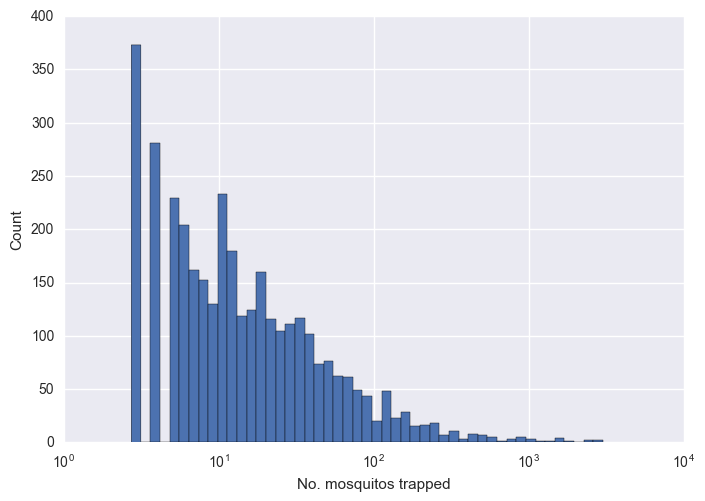

In [36]:
bins = np.linspace(1.,np.max(np.log(mosCount)));
bins = np.exp(bins)
plt.hist(mosCount,bins=bins);
plt.xscale('log');plt.xlabel('No. mosquitos trapped');
plt.ylabel('Count');

## Investigate Spray data

In [42]:
df_spray = pd.read_csv('./data/spray.csv')

In [43]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


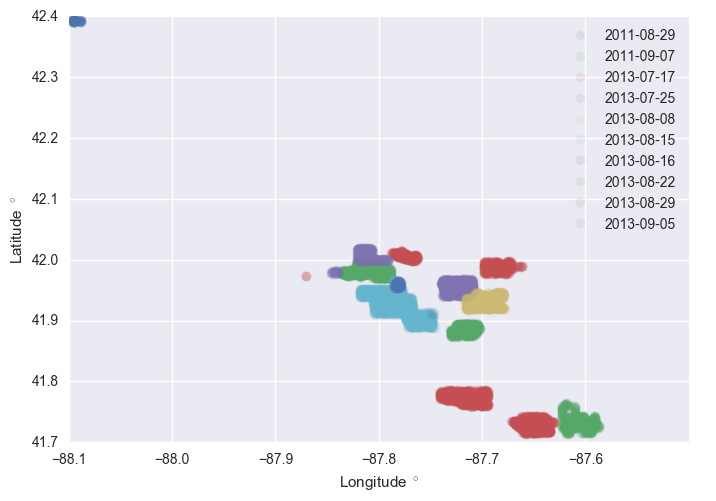

In [49]:
for date in df_spray['Date'].unique():
    dates = df_spray['Date'] == date
    plt.plot(df_spray[dates]['Longitude'],df_spray[dates]['Latitude'],'o',alpha=0.1,label=date);
plt.legend();
plt.xlabel('Longitude $^\circ$');
plt.ylabel('Latitude $^\circ$');

In [48]:
value = df_spray['Latitude'][0]
df_train.ix[(df_train['Latitude']-value).abs().argsort()[:2]]

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
6455,2011-07-11,"7500 North Oakley Avenue, Chicago, IL 60645, USA",CULEX RESTUANS,75,N OAKLEY AVE,T148,"7500 N OAKLEY AVE, Chicago, IL",42.01743,-87.687769,8,23,0
5076,2009-07-31,"7500 North Oakley Avenue, Chicago, IL 60645, USA",CULEX PIPIENS/RESTUANS,75,N OAKLEY AVE,T148,"7500 N OAKLEY AVE, Chicago, IL",42.01743,-87.687769,8,3,0


## Feature engineering

In [49]:
df_train['Date'] = pd.to_datetime(df_train['Date'])


In [50]:
ndf = df_train.groupby(['Date']).count().reset_index()
ndf['Date'] = pd.to_datetime(ndf['Date'])

mdf = df_test.groupby(['Date']).count().reset_index()
mdf['Date'] = pd.to_datetime(mdf['Date'])



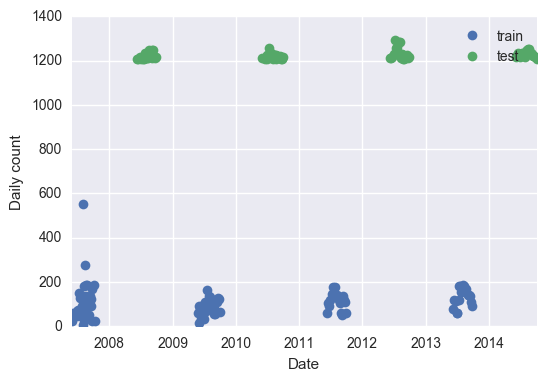

In [51]:
plt.plot(ndf['Date'],ndf['Trap'],'o',label='train');
plt.plot(mdf['Date'],mdf['Trap'],'o',label='test');
plt.xlabel('Date');
plt.ylabel('Daily count');
plt.legend();

In [65]:
means = df_train.groupby('Date').mean().reset_index()
means['Date'] = pd.to_datetime(means['Date'])

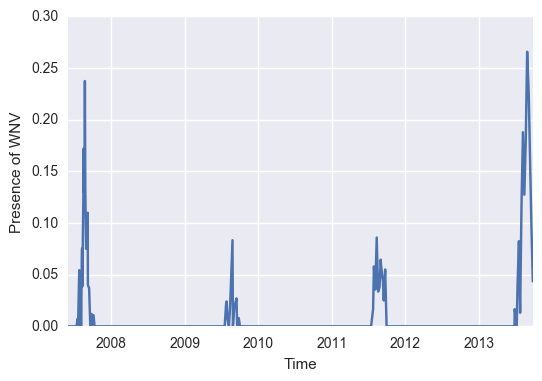

In [66]:
plt.plot(means['Date'],means['WnvPresent']);
plt.ylabel('Presence of WNV');
plt.xlabel('Time');

In [39]:
means.columns

Index([u'Date', u'Block', u'Latitude', u'Longitude', u'AddressAccuracy',
       u'NumMosquitos', u'WnvPresent'],
      dtype='object')

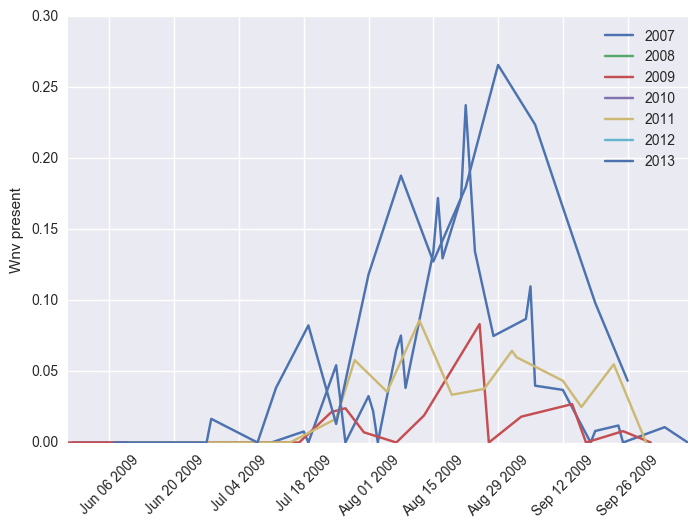

In [52]:
for year in np.arange(2007,2014).astype(str):
    yr = means[(means['Date'] > year+'-01-01') & (means['Date'] < year+'-12-30')]
    dates = pd.to_datetime(yr['Date'].map(lambda x: x.strftime('2009-%m-%d')))
    
    plt.plot(dates,yr['WnvPresent'],label=year);
plt.xticks(rotation=45);
plt.ylabel('Wnv present');
plt.legend();


## Create some features with KDE
IDEA: if mosquitos are nearby then west-nile virus is likely being transmitted


In [67]:
from sklearn.neighbors import KernelDensity

In [68]:
def convertColumnToWeeks(col):
    return np.floor((pd.to_datetime(col) - datetime.datetime(2007,01,01)).dt.days/7.).astype(int)

In [69]:
df_train['weeks_since_start'] = convertColumnToWeeks(df_train['Date'])

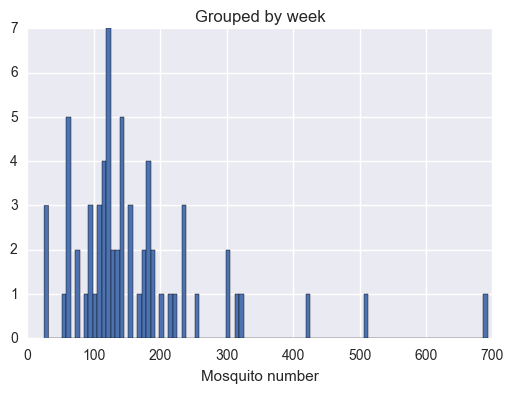

In [71]:
ndf = df_train.groupby('weeks_since_start').count().reset_index()
plt.hist(ndf['NumMosquitos'],bins=100);
plt.title('Grouped by week');
plt.xlabel('Mosquito number');

Seems like aggregating into weeks is a good idea.

In [81]:
ndf = df_train.groupby('weeks_since_start').sum().reset_index()

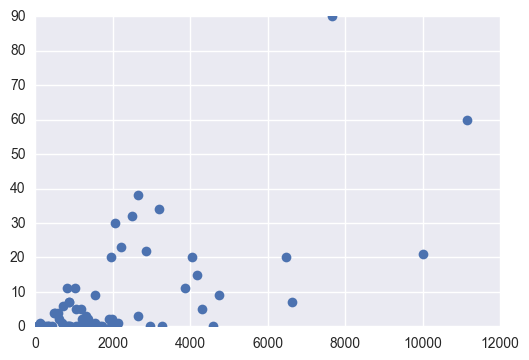

In [83]:
plt.plot(ndf['NumMosquitos'],ndf['WnvPresent'],'o');

In [73]:
Xs = df_train[df_train['WnvPresent']==1][['Longitude','Latitude']].get_values()
kde = KernelDensity(bandwidth=0.02, 
                    kernel='gaussian')
kde.fit(Xs)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.02, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [74]:
Y,X = np.meshgrid(np.linspace(-88.1,-87.4),np.linspace(41.7,42.05))
xy = np.vstack([Y.ravel(), X.ravel()]).T
scores = np.exp(kde.score_samples(xy)).reshape(X.shape)

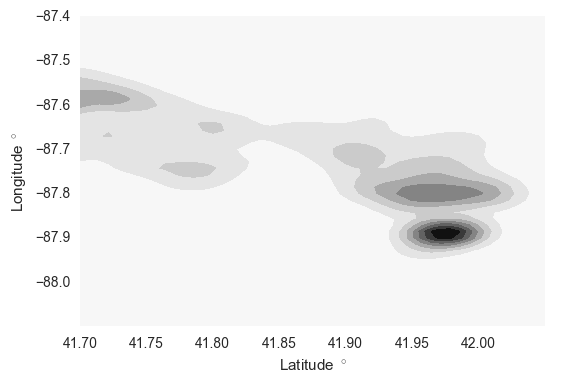

In [78]:
plt.contourf(X, Y, scores);
plt.xlabel('Latitude $^\circ$');
plt.ylabel('Longitude $^\circ$');

IDEA: Use these as scores, maybe if WNV was there before it's more likely to occur again

In [134]:
Xs = df_train[['Longitude','Latitude']].get_values()
df_train['pWNV1'] = np.exp(kde.score_samples(Xs))

In [ ]:
def wnvPresentFeature(df_train,df):
    '''
    Take in df_train to train kde and output column
    in df
    returns df with new column
    '''
    Xs = df_train[df_train['WnvPresent']==1][['Longitude','Latitude']].get_values() #take only values where WNV present.
    kde = KernelDensity(bandwidth=0.02, 
                        kernel='gaussian')
    kde.fit(Xs)
    
    
    Xs = df[['Longitude','Latitude']].get_values()
    df['pWNV1'] = np.exp(kde.score_samples(Xs))

    return df

## Feature generation using GPR

In [79]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

In [80]:
inds = df_train['weeks_since_start']==25
X = df_train[inds][['Longitude','Latitude']].get_values()
y = df_train[inds]['NumMosquitos'].get_values()
gpr = GaussianProcessRegressor(kernel=kernels.Matern(length_scale=0.1))
gpr.fit(X,y)

//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-1769472.]), 'nit': 3, 'funcalls': 84}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=Matern(length_scale=0.1, nu=1.5),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [81]:
Y,X = np.meshgrid(np.linspace(-88.1,-87.4),np.linspace(41.65,42.05))
xy = np.vstack([Y.ravel(), X.ravel()]).T
predictions = gpr.predict(xy).reshape(X.shape)
Xp = df_train[inds][['Longitude','Latitude']].get_values()

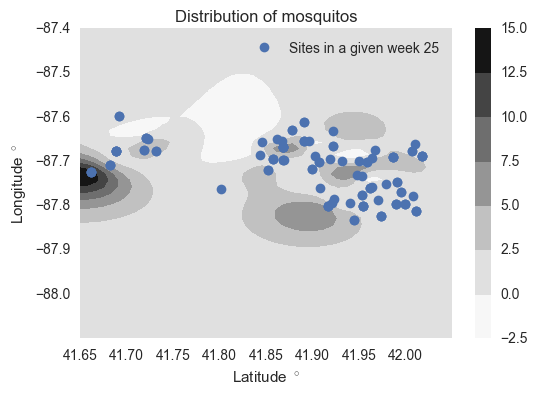

In [84]:
plt.contourf(X,Y,predictions);
plt.plot(Xp[:,1],Xp[:,0],'o',label='Sites in a given week 25');
plt.legend();
plt.title('Distribution of mosquitos');
plt.xlabel('Latitude $^\circ$');
plt.ylabel('Longitude $^\circ$');
plt.colorbar();

In [85]:
def mosquitoPresenceFeature(df):
    pMos1 = np.zeros(len(df.index))
    for week in df['weeks_since_start'].unique():
        print("Week: {}".format(week))
        inds = df['weeks_since_start']==week
        X = df[inds][['Longitude','Latitude']].get_values()
        y = df[inds]['NumMosquitos'].get_values()
        gpr = GaussianProcessRegressor(kernel=kernels.Matern(length_scale=0.1))
        gpr.fit(X,y)
        
        pMos1[inds] = gpr.predict(X)
    df['pMos1'] = pMos1
    return df

In [86]:
df_train = mosquitoPresenceFeature(df_train)

Week: 21
Week: 22
Week: 25


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-302489.99011612]), 'nit': 3, 'funcalls': 52}
  " state: %s" % convergence_dict)


Week: 26
Week: 27
Week: 28


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 2673438.34429675]), 'nit': 1, 'funcalls': 47}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-39780352.]), 'nit': 1, 'funcalls': 47}
  " state: %s" % convergence_dict)


Week: 29
Week: 30


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.59129344e+08]), 'nit': 2, 'funcalls': 62}
  " state: %s" % convergence_dict)


Week: 31


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.56515840e+08]), 'nit': 4, 'funcalls': 72}
  " state: %s" % convergence_dict)


Week: 32


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.13070643e+09]), 'nit': 1, 'funcalls': 46}
  " state: %s" % convergence_dict)


Week: 33
Week: 34
Week: 35


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 196608.]), 'nit': 4, 'funcalls': 54}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.20200960e+08]), 'nit': 3, 'funcalls': 66}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 21987328.]), 'nit': 1, 'funcalls': 28}
  " state: %s" % convergence_dict)


Week: 36
Week: 37
Week: 38


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-32833536.]), 'nit': 2, 'funcalls': 60}
  " state: %s" % convergence_dict)


Week: 39


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  7.29808896e+08]), 'nit': 3, 'funcalls': 71}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-3690145.73913574]), 'nit': 1, 'funcalls': 43}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-49020928.]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)


Week: 40
Week: 125
Week: 126
Week: 127


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.38412032e+08]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-67371008.]), 'nit': 3, 'funcalls': 53}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.52321536e+08]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)


Week: 128
Week: 129
Week: 130
Week: 131
Week: 132
Week: 133
Week: 134
Week: 135


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-23855104.]), 'nit': 4, 'funcalls': 68}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-60817408.]), 'nit': 2, 'funcalls': 53}
  " state: %s" % convergence_dict)


Week: 136
Week: 138


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.67772160e+08]), 'nit': 3, 'funcalls': 67}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 1048576.]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)


Week: 139
Week: 141
Week: 142
Week: 143
Week: 231
Week: 232
Week: 233


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.64740608e+08]), 'nit': 1, 'funcalls': 30}
  " state: %s" % convergence_dict)


Week: 234
Week: 236


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -5.41065216e+08]), 'nit': 4, 'funcalls': 73}
  " state: %s" % convergence_dict)


Week: 238


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.27155712e+08]), 'nit': 2, 'funcalls': 84}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-4030464.]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)


Week: 239
Week: 240
Week: 241


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 4718592.]), 'nit': 3, 'funcalls': 49}
  " state: %s" % convergence_dict)


Week: 242
Week: 243
Week: 245
Week: 246
Week: 247
Week: 335
Week: 336
Week: 337


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-7340032.]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-10485760.]), 'nit': 2, 'funcalls': 63}
  " state: %s" % convergence_dict)


Week: 338
Week: 340


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 13008530.34375]), 'nit': 2, 'funcalls': 54}
  " state: %s" % convergence_dict)


Week: 341
Week: 342
Week: 343
Week: 344


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.04857600e+08]), 'nit': 2, 'funcalls': 59}
  " state: %s" % convergence_dict)


Week: 345
Week: 346
Week: 347
Week: 348
Week: 349
Week: 350


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-10485760.]), 'nit': 1, 'funcalls': 46}
  " state: %s" % convergence_dict)
//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-2378633.6875]), 'nit': 1, 'funcalls': 43}
  " state: %s" % convergence_dict)


Week: 351


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 427069.92578125]), 'nit': 2, 'funcalls': 58}
  " state: %s" % convergence_dict)


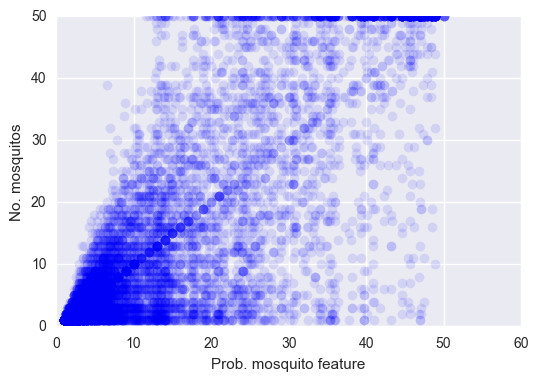

In [88]:
plt.plot(df_train['pMos1'],df_train['NumMosquitos'],'bo',alpha=0.1);
plt.xlabel('Prob. mosquito feature');
plt.ylabel('No. mosquitos');

### Number of mosquitos not present in test data so we have to re-think gpr feature

just split into week of the year and use that

In [93]:
df_train['week'] = pd.to_datetime(df_train['Date']).dt.week
df_test['week'] = pd.to_datetime(df_test['Date']).dt.week

In [98]:
def mosquitoPresenceFeature(train,test):
    pMos_train = np.zeros(len(train.index))
    pMos_test = np.zeros(len(test.index))
    for week in train['week'].unique():
        print("Week: {}".format(week))
        inds = train['week']==week
        X = train[inds][['Longitude','Latitude']].get_values()
        y = train[inds]['NumMosquitos'].get_values()
        gpr = GaussianProcessRegressor(kernel=kernels.Matern(length_scale=0.1))
        gpr.fit(X,y)
        
        pMos_train[inds] = gpr.predict(X)
        
        #now use model to predict on test data
        inds = test['week']==week
        X = test[inds][['Longitude','Latitude']].get_values()
        if X.size > 0:
            pMos_test[inds] = gpr.predict(X)
        
    train['pMos1'] = pMos_train
    test['pMos1'] = pMos_test
    return train,test

In [99]:
df_train,df_test = mosquitoPresenceFeature(df_train,df_test)

Week: 22
Week: 23
Week: 26
Week: 27
Week: 28
Week: 29
Week: 30
Week: 31
Week: 32
Week: 33
Week: 34
Week: 35
Week: 36
Week: 37
Week: 38
Week: 39
Week: 40
Week: 41
Week: 24
Week: 25


//anaconda/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.19957094e+09]), 'nit': 2, 'funcalls': 56}
  " state: %s" % convergence_dict)


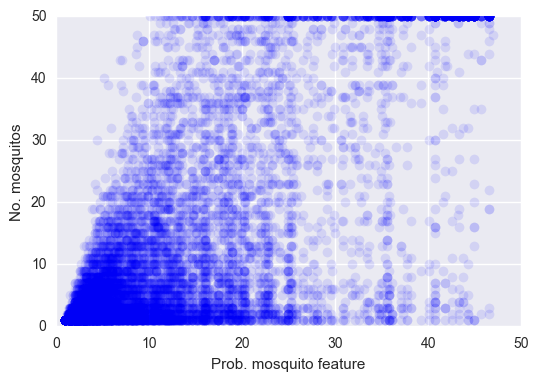

In [100]:
plt.plot(df_train['pMos1'],df_train['NumMosquitos'],'bo',alpha=0.1);
plt.xlabel('Prob. mosquito feature');
plt.ylabel('No. mosquitos');